# Marketing Attribution Models using Markov Chains

EDA


In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict

df = pd.read_csv('attribution data.csv')
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display


In [4]:
df['visit_order'] = df.groupby('cookie').cumcount() + 1
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2


# Transform the dataset represents a user cookie

In [5]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()

df_paths.head()

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


# cookie and conversion state of the last interaction

In [7]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_last_interaction.head()

,cookie,conversion
586736,ooooohAFofEnonEikhAi3fF9o,0
586735,ooooiBh70D3k3BfAhDFfii9h7,0
586733,ooooEiB0CCoEf9fiiC90Dfhfk,0
586730,ooooEBE0o0D97ACAAAnDoi3F0,0
586729,ooooE0hkAFBkED90ChDDiBFAf,0


# COOKIE + CONVERSION

In [8]:
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0


# CUSTOMERS PATH

In [11]:
df_paths_copy = df_paths.copy()

In [ ]:
# init empty
df_paths_copy['path'] = np.repeat([""], repeats=df_paths_copy.shape[0])

# assign
for i in range(df_paths_copy.shape[0]):
    if df_paths_copy['conversion'][i] == 0:
        df_paths_copy['path'][i] = ['Start'] + df_paths_copy['channel'][i] + ['Null']
    else:
        df_paths_copy['path'][i] = ['Start'] + df_paths_copy['channel'][i] + ['Conversion']


Head

In [ ]:
df_paths_copy = df_paths_copy[['cookie', 'path']]
df_paths_copy.head()

# Transition Probability Matrix


__List of ALL User journeys__

In [43]:
list_of_paths = df_paths_copy['path']
total_conversions = sum(path.count('Conversion') for path in df_paths_copy['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)
print("Conversion Rate:", base_conversion_rate)

Conversion Rate: 0.07346277508454528


In [45]:
# Count the occurences of various transitions
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states

trans_states = transition_states(list_of_paths)
trans_states

{'Null>Null': 0,
 'Null>Facebook': 0,
 'Null>Online Display': 0,
 'Null>Instagram': 0,
 'Null>Start': 0,
 'Null>Paid Search': 0,
 'Null>Conversion': 0,
 'Null>Online Video': 0,
 'Facebook>Null': 59319,
 'Facebook>Facebook': 0,
 'Facebook>Online Display': 2146,
 'Facebook>Instagram': 15252,
 'Facebook>Start': 0,
 'Facebook>Paid Search': 4464,
 'Facebook>Conversion': 4690,
 'Facebook>Online Video': 2254,
 'Online Display>Null': 32236,
 'Online Display>Facebook': 2300,
 'Online Display>Online Display': 0,
 'Online Display>Instagram': 1251,
 'Online Display>Start': 0,
 'Online Display>Paid Search': 3936,
 'Online Display>Conversion': 2144,
 'Online Display>Online Video': 737,
 'Instagram>Null': 31153,
 'Instagram>Facebook': 10822,
 'Instagram>Online Display': 1164,
 'Instagram>Instagram': 0,
 'Instagram>Start': 0,
 'Instagram>Paid Search': 2266,
 'Instagram>Conversion': 2868,
 'Instagram>Online Video': 1193,
 'Start>Null': 0,
 'Start>Facebook': 66848,
 'Start>Online Display': 34250,
 'Star


Function to calculate transition probabilities

In [47]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)
trans_prob

defaultdict(dict,
            {'Facebook>Null': 0.6731234042553191,
             'Facebook>Online Display': 0.02435177304964539,
             'Facebook>Instagram': 0.1730723404255319,
             'Facebook>Paid Search': 0.05065531914893617,
             'Facebook>Conversion': 0.053219858156028366,
             'Facebook>Online Video': 0.025577304964539006,
             'Online Display>Null': 0.7566425687728852,
             'Online Display>Facebook': 0.053985541263731104,
             'Online Display>Instagram': 0.02936344005257722,
             'Online Display>Paid Search': 0.09238569148436766,
             'Online Display>Conversion': 0.05032391324758239,
             'Online Display>Online Video': 0.017298845178856444,
             'Instagram>Null': 0.6297861157158452,
             'Instagram>Facebook': 0.2187765333764606,
             'Instagram>Online Display': 0.023531314438199977,
             'Instagram>Paid Search': 0.04580924271216593,
             'Instagram>Conversion': 0.

transition probabilities to a matrix.

In [49]:
# Transform the dict to a Transition probability matrix
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)
trans_matrix

,Null,Facebook,Online Display,Instagram,Start,Paid Search,Conversion,Online Video
Null,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
Facebook,0.673123,0.000000,0.024352,0.173072,0.0,0.050655,0.053220,0.025577
Online Display,0.756643,0.053986,0.000000,0.029363,0.0,0.092386,0.050324,0.017299
Instagram,0.629786,0.218777,0.023531,0.000000,0.0,0.045809,0.057979,0.024118
Start,0.000000,0.278408,0.142644,0.119188,0.0,0.317399,0.000000,0.142361
Paid Search,0.770779,0.064442,0.048053,0.034196,0.0,0.000000,0.053309,0.029221
Conversion,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000
Online Video,0.763757,0.059323,0.018920,0.031908,0.0,0.047947,0.078146,0.000000


# Heatmap

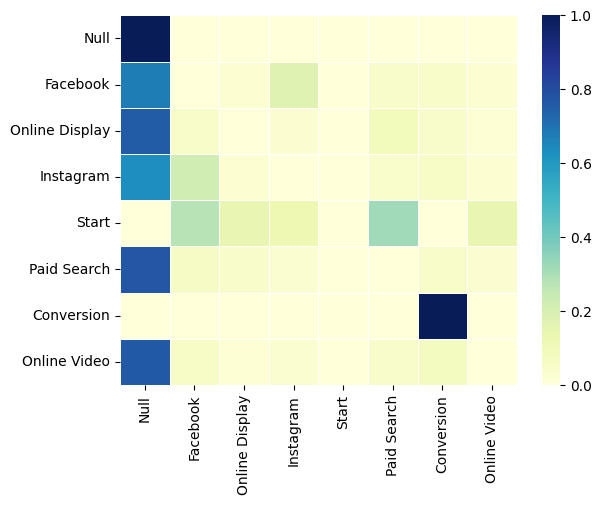

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

ax = sns.heatmap(trans_matrix, linewidth=0.5, cmap="YlGnBu")
plt.show()

Ad-Channel Impact 

In [52]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)
removal_effects_dict

{'Facebook': 0.3547597674182721,
 'Online Display': 0.15435482356041275,
 'Instagram': 0.21731366149038456,
 'Paid Search': 0.3311037560086154,
 'Online Video': 0.20691411655642178}

conversions impact by each channel

In [54]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)
attributions

{'Facebook': 4948.892177847523,
 'Online Display': 2153.2469267590823,
 'Instagram': 3031.521548555893,
 'Paid Search': 4618.891257291356,
 'Online Video': 2886.4480895461456}